In [1]:
import pandas as pd

In [11]:
test_df = pd.read_csv("/home/work/ocular_surface_disease/daeeon/[External]Temporally_separated.csv")
test_df

,Patient_id,filename,Observation,A,B,Effusion,Consolidation
0,10142141,10142141_00002.png,A,1,0,0,0
1,10142141,10142141_00003.png,A,1,0,0,0
2,10142141,10142141_00004.png,A,1,0,0,0
3,10142141,10142141_00007.png,A,1,0,0,0
4,10142141,10142141_00008.png,A,1,0,0,0
...,...,...,...,...,...,...,...
980,70625934,70625934_00018.png,A,1,0,0,0
981,70625934,70625934_00019.png,A,1,0,0,0
982,70625934,70625934_00025.png,Effusion,0,0,1,0
983,74627297,74627297_00000.png,"B line, Effusion",0,1,1,0


In [12]:
test_df.Patient_id.nunique()

146

In [13]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


Youden_Threshold =  [0.207, 0.233, 0.641, 0.236]


def get_true_pos(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [0.2074, 0.2328, 0.6411, 0.2357] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round((tp(y[:, i], pred[:, i])//4),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round((tn(y[:, i], pred[:, i])//4),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round((fp(y[:, i], pred[:, i])//4),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round((fn(y[:, i], pred[:, i])//4),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df



def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

            
def true_positives(y, pred, th=Youden_Threshold):
    TP = 0    
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    return TP

def true_negatives(y, pred, th=Youden_Threshold):
    TN = 0
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TN
    TN = np.sum((y == 0 ) & (thresholded_preds == 0 ))
    return TN

def false_positives(y, pred, th=Youden_Threshold):
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    return FP

def false_negatives(y, pred, th=Youden_Threshold):
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    return FN


def get_accuracy(y, pred, th=Youden_Threshold):
    accuracy = 0.0
    TP = true_positives(y, pred, th)   
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y,pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / ( TP + FP + TN + FN)
    
    return accuracy

def get_prevalence(y):
    prevalence = 0.0
    prevalence = np.mean(y)
    return prevalence


def get_sensitivity(y, pred, th=Youden_Threshold):

    sensitivity = 0.0
    # get TP and FN using our previously defined functions
    TP = true_positives(y,pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    return sensitivity

def get_specificity(y, pred, th=Youden_Threshold):
    specificity = 0.0
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y,pred, th)
    FP = false_positives(y, pred, th)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    return specificity


def get_ppv(y, pred, th=Youden_Threshold):
    PPV = 0.0
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)

    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    return PPV

def get_npv(y, pred, th=Youden_Threshold):
    NPV = 0.0
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    return NPV


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
                   "Sensitivity",
                   "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round((tp(y[:, i], pred[:, i])//4),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round((tn(y[:, i], pred[:, i])//4),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round((fp(y[:, i], pred[:, i])//4),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round((fn(y[:, i], pred[:, i])//4),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df



In [14]:
pred_test = pd.read_csv("/home/work/ocular_surface_disease/daeeon/result/SNUH_temporally_seperated.csv")
pred_test

,A_pred,B_pred,Effusion_pred,Consolidation_pred
0,0.407716,0.449583,0.093202,0.041649
1,0.207990,0.700836,0.124267,0.079153
2,0.589567,0.400333,0.061523,0.058921
3,0.530469,0.360835,0.098367,0.072571
4,0.725252,0.097848,0.079550,0.022385
...,...,...,...,...
980,0.422635,0.675980,0.311165,0.199501
981,0.626270,0.505468,0.259196,0.270970
982,0.453767,0.539063,0.400045,0.399070
983,0.052468,0.118760,0.854368,0.442317


In [16]:
test_df

,Patient_id,filename,Observation,A,B,Effusion,Consolidation
0,10142141,10142141_00002.png,A,1,0,0,0
1,10142141,10142141_00003.png,A,1,0,0,0
2,10142141,10142141_00004.png,A,1,0,0,0
3,10142141,10142141_00007.png,A,1,0,0,0
4,10142141,10142141_00008.png,A,1,0,0,0
...,...,...,...,...,...,...,...
980,70625934,70625934_00018.png,A,1,0,0,0
981,70625934,70625934_00019.png,A,1,0,0,0
982,70625934,70625934_00025.png,Effusion,0,0,1,0
983,74627297,74627297_00000.png,"B line, Effusion",0,1,1,0


In [18]:
true_list = test_df.iloc[:,3:]
true_list

,A,B,Effusion,Consolidation
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
980,1,0,0,0
981,1,0,0,0
982,0,0,1,0
983,0,1,1,0


In [19]:
y_list = true_list.to_numpy()

In [20]:
valid_results = pd.concat([true_list, pred_test], axis = 1)
valid_results

,A,B,Effusion,Consolidation,A_pred,B_pred,Effusion_pred,Consolidation_pred
0,1,0,0,0,0.407716,0.449583,0.093202,0.041649
1,1,0,0,0,0.207990,0.700836,0.124267,0.079153
2,1,0,0,0,0.589567,0.400333,0.061523,0.058921
3,1,0,0,0,0.530469,0.360835,0.098367,0.072571
4,1,0,0,0,0.725252,0.097848,0.079550,0.022385
...,...,...,...,...,...,...,...,...
980,1,0,0,0,0.422635,0.675980,0.311165,0.199501
981,1,0,0,0,0.626270,0.505468,0.259196,0.270970
982,0,0,1,0,0.453767,0.539063,0.400045,0.399070
983,0,1,1,0,0.052468,0.118760,0.854368,0.442317


In [21]:
class_labels = ['A', 'B', 'Effusion', 'Consolidation']
pred_labels = [l + "_pred" for l in class_labels]

y = valid_results[class_labels].values
pred = valid_results[pred_labels].values
valid_results[np.concatenate([class_labels, pred_labels])].head()



,A,B,Effusion,Consolidation,A_pred,B_pred,Effusion_pred,Consolidation_pred
0,1,0,0,0,0.407716,0.449583,0.093202,0.041649
1,1,0,0,0,0.207990,0.700836,0.124267,0.079153
2,1,0,0,0,0.589567,0.400333,0.061523,0.058921
3,1,0,0,0,0.530469,0.360835,0.098367,0.072571
4,1,0,0,0,0.725252,0.097848,0.079550,0.022385


In [28]:

from sklearn.metrics import f1_score



In [23]:
def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg, acc=None, prevalence=None,
                            spec=None, sens=None, ppv=None, npv=None,
                            auc=None, f1=None, thresholds=[],
                            n_bootstraps=1000):
    if len(thresholds) != len(class_labels):
        thresholds = [0.2074, 0.2328, 0.6411, 0.2357] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity", "Specificity", "PPV", "NPV", "AUC", "AUC CI",
               "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round((tp(y[:, i], pred[:, i])//4), 3) if tp != None else "Not Defined"
        df.loc[i][2] = round((tn(y[:, i], pred[:, i])//4), 3) if tn != None else "Not Defined"
        df.loc[i][3] = round((fp(y[:, i], pred[:, i])//4), 3) if fp != None else "Not Defined"
        df.loc[i][4] = round((fn(y[:, i], pred[:, i])//4), 3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]), 3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]), 3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]), 3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]), 3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]), 3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]), 3) if npv != None else "Not Defined"
        mean_auc, lower_ci, upper_ci = bootstrap_auc(y[:, i], pred[:, i], n_bootstraps)
        df.loc[i][11] = round(mean_auc, 3)
        df.loc[i][12] = f"({round(lower_ci, 3)}-{round(upper_ci, 3)})"
        df.loc[i][13] = round(f1(y[:, i], pred[:, i] > thresholds[i]), 3) if f1 != None else "Not Defined"
        df.loc[i][14] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

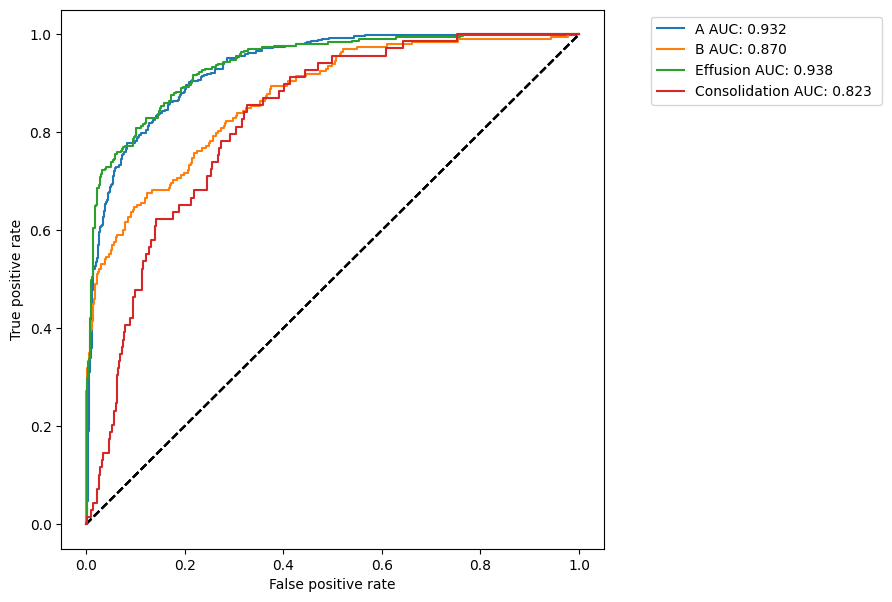

In [24]:


get_curve(y, pred, class_labels)


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    f1_score,
)


Youden_Threshold = [0.207, 0.233, 0.641, 0.236]


def get_true_pos(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=Youden_Threshold):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_accuracy(y, pred, th=Youden_Threshold):
    tp = get_true_pos(y, pred, th)
    tn = get_true_neg(y, pred, th)
    fp = get_false_pos(y, pred, th)
    fn = get_false_neg(y, pred, th)
    return (tp + tn) / (tp + tn + fp + fn)


def get_prevalence(y):
    return np.mean(y)


def get_sensitivity(y, pred, th=Youden_Threshold):
    tp = get_true_pos(y, pred, th)
    fn = get_false_neg(y, pred, th)
    return tp / (tp + fn)


def get_specificity(y, pred, th=Youden_Threshold):
    tn = get_true_neg(y, pred, th)
    fp = get_false_pos(y, pred, th)
    return tn / (tn + fp)


def get_ppv(y, pred, th=Youden_Threshold):
    tp = get_true_pos(y, pred, th)
    fp = get_false_pos(y, pred, th)
    return tp / (tp + fp)


def get_npv(y, pred, th=Youden_Threshold):
    tn = get_true_neg(y, pred, th)
    fn = get_false_neg(y, pred, th)
    return tn / (tn + fn)


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=get_accuracy, prevalence=get_prevalence, spec=get_specificity,
                            sens=get_sensitivity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=Youden_Threshold):
    if len(thresholds) != len(class_labels):
        thresholds = [0.207, 0.233, 0.641, 0.236] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity", "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i], thresholds[i]), 3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i], thresholds[i]), 3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i], thresholds[i]), 3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i], thresholds[i]), 3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]), 3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]), 3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]), 3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]), 3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]), 3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]), 3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]), 3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], (pred[:, i] > thresholds[i]).astype(int)), 3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def bootstrap_evaluation(y, pred, class_labels, n_iterations=1000):
    statistics = np.zeros((len(class_labels), n_iterations))
    for i in range(n_iterations):
        indices = np.random.choice(range(y.shape[0]), size=y.shape[0], replace=True)
        y_sample = y[indices]
        pred_sample = pred[indices]
        for j in range(len(class_labels)):
            statistics[j, i] = roc_auc_score(y_sample[:, j], pred_sample[:, j])
    return statistics


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.3f (%.3f-%.3f)" % (mean, min_, max_)]
    return df



In [26]:

# Bootstrap evaluation
statistics = bootstrap_evaluation(y, pred, class_labels)


In [27]:

# Print confidence intervals
print_confidence_intervals(class_labels, statistics)


,Mean AUC (CI 5%-95%)
A,0.931 (0.918-0.944)
B,0.870 (0.844-0.893)
Effusion,0.938 (0.924-0.951)
Consolidation,0.822 (0.785-0.856)
